In [4]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# file_path = "Processed_Data/Mapped_Dataset.csv"
# file_path="C:/Users/hoang/FileCSV_DACN_2025/Benign_ddos_dos_Mapped_Dataset.csv"
file_path = "/content/drive/MyDrive/Colab_Notebooks/balanced_scaled_dataset.csv"

df = dk.read_csv(file_path)

label
0    1098195
4    3000003
6    2634124
Name: count, dtype: int64


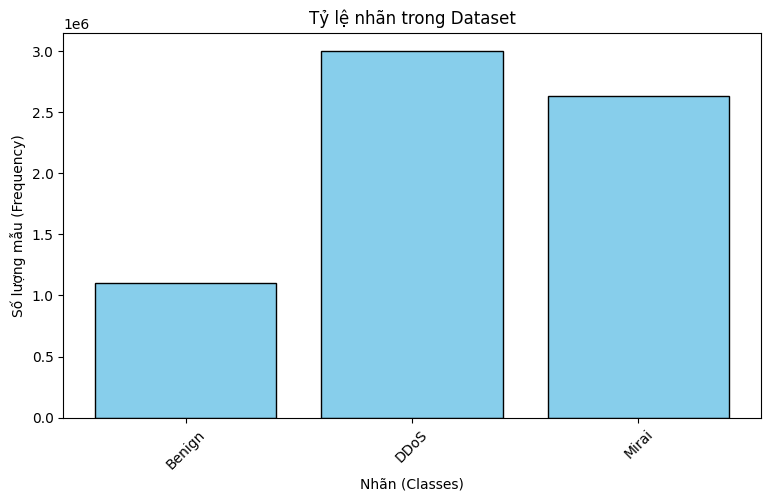

In [5]:
import matplotlib.pyplot as plt

# labels = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood',
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().compute()
print(label_counts)
labels = ["Benign","DDoS","Mirai"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [3]:
import dask.dataframe as dk
import pandas as pd
import numpy as np
from dask.diagnostics import ProgressBar
from sklearn.preprocessing import StandardScaler
import os
import time
import shutil

def l2_normalize(x):
    """Chuẩn hóa L2 cho một vector hoặc DataFrame."""
    norm = np.linalg.norm(x, axis=1, keepdims=True)
    return x / np.where(norm == 0, 1, norm)  # Tránh chia 0

def process_large_dataset(input_csv, output_csv, target_ddos=2000000, chunk_size=200000):
    print("Bắt đầu xử lý dataset cực lớn...")
    start_time = time.time()

    # Thư mục tạm
    temp_dir = f"temp_chunks_{int(time.time())}"
    os.makedirs(temp_dir, exist_ok=True)

    try:
        # 1. Đếm tổng số mẫu DDoS
        print("Đang đếm tổng số mẫu DDoS...")
        ddf = dk.read_csv(input_csv)
        total_ddos = ddf[ddf['label'] == 4].shape[0].compute()
        print(f"Tổng số mẫu DDoS: {total_ddos:,}")

        # 2. Tính toán tỷ lệ lấy mẫu
        sample_frac_ddos = min(target_ddos / total_ddos, 1.0)  # Đảm bảo ≤ 1
        print(f"Tỷ lệ lấy mẫu DDoS: {sample_frac_ddos:.4f}")

        # 3. Khởi tạo StandardScaler (cần fit trên toàn bộ dữ liệu)
        print("Tính toán mean và std cho StandardScaler...")
        numeric_cols = ddf.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols.remove('label')  # Loại bỏ cột nhãn
        scaler = StandardScaler()

        # Fit scaler trên một subset ngẫu nhiên (tiết kiệm bộ nhớ)
        sample_for_fit = ddf.sample(frac=0.1).compute()
        scaler.fit(sample_for_fit[numeric_cols])

        # 4. Xử lý từng chunk
        print("Bắt đầu xử lý từng chunk...")
        reader = pd.read_csv(input_csv, chunksize=chunk_size)

        sampled_ddos = []
        processed_chunks = 0
        first_benign_chunk = True
        first_mirai_chunk = True

        for chunk in reader:
            # Chuẩn hóa dữ liệu số
            chunk_numeric = chunk[numeric_cols]
            chunk[numeric_cols] = scaler.transform(chunk_numeric)
            chunk[numeric_cols] = l2_normalize(chunk[numeric_cols])

            # Lọc và lấy mẫu DDoS
            ddos_chunk = chunk[chunk['label'] == 4]
            if not ddos_chunk.empty:
                sampled = ddos_chunk.sample(frac=sample_frac_ddos, random_state=42)
                sampled_ddos.append(sampled)

            # Ghi Benign chunks
            benign_chunk = chunk[chunk['label'] == 0]
            if not benign_chunk.empty:
                benign_path = os.path.join(temp_dir, "benign.csv")
                benign_chunk.to_csv(
                    benign_path,
                    index=False,
                    mode='a',
                    header=first_benign_chunk
                )
                first_benign_chunk = False

            # Ghi Mirai chunks
            mirai_chunk = chunk[chunk['label'] == 6]
            if not mirai_chunk.empty:
                mirai_path = os.path.join(temp_dir, "mirai.csv")
                mirai_chunk.to_csv(
                    mirai_path,
                    index=False,
                    mode='a',
                    header=first_mirai_chunk
                )
                first_mirai_chunk = False

            processed_chunks += 1
            if processed_chunks % 10 == 0:
                print(f"Đã xử lý {processed_chunks} chunks...")

        # 5. Ghi mẫu DDoS đã lấy
        if sampled_ddos:
            final_ddos = pd.concat(sampled_ddos)
            final_ddos.to_csv(
                os.path.join(temp_dir, "ddos_samples.csv"),
                index=False
            )

        # 6. Hợp nhất các file tạm
        print("Đang hợp nhất các file tạm...")
        files_to_merge = []
        if os.path.exists(os.path.join(temp_dir, "ddos_samples.csv")):
            files_to_merge.append(dk.read_csv(os.path.join(temp_dir, "ddos_samples.csv")))
        if os.path.exists(os.path.join(temp_dir, "mirai.csv")):
            files_to_merge.append(dk.read_csv(os.path.join(temp_dir, "mirai.csv")))
        if os.path.exists(os.path.join(temp_dir, "benign.csv")):
            files_to_merge.append(dk.read_csv(os.path.join(temp_dir, "benign.csv")))

        balanced = dk.concat(files_to_merge) if files_to_merge else None

        # 7. Ghi file kết quả
        if balanced is not None:
            with ProgressBar():
                balanced.to_csv(
                    output_csv,
                    index=False,
                    single_file=True
                )

            # Thống kê
            final_count = balanced.shape[0].compute()
            final_ddos_count = balanced[balanced['label'] == 4].shape[0].compute() if 'ddos_samples.csv' in os.listdir(temp_dir) else 0
            final_mirai_count = balanced[balanced['label'] == 6].shape[0].compute() if 'mirai.csv' in os.listdir(temp_dir) else 0

            print("\n" + "="*50)
            print(f"HOÀN THÀNH! File đã được lưu tại: {output_csv}")
            print(f"Tổng số mẫu: {final_count:,}")
            print(f"- Mẫu DDoS: {final_ddos_count:,} ({(final_ddos_count/final_count)*100:.1f}%)")
            print(f"- Mẫu Mirai: {final_mirai_count:,} ({(final_mirai_count/final_count)*100:.1f}%)")
            print(f"Thời gian xử lý: {(time.time()-start_time)/60:.2f} phút")
            print("="*50)
        else:
            print("Không có dữ liệu để hợp nhất!")

    finally:
        # Dọn dẹp thư mục tạm
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)

if __name__ == "__main__":
    process_large_dataset(
        input_csv='/content/drive/MyDrive/Colab_Notebooks/Mapped_Dataset.csv',
        output_csv='/content/drive/MyDrive/Colab_Notebooks/balanced_scaled_dataset.csv',
        target_ddos=3000000,
        chunk_size=300000
    )

Bắt đầu xử lý dataset cực lớn...
Đang đếm tổng số mẫu DDoS...
Tổng số mẫu DDoS: 33,984,560
Tỷ lệ lấy mẫu DDoS: 0.0883
Tính toán mean và std cho StandardScaler...
Bắt đầu xử lý từng chunk...
Đã xử lý 10 chunks...
Đã xử lý 20 chunks...
Đã xử lý 30 chunks...
Đã xử lý 40 chunks...
Đã xử lý 50 chunks...
Đã xử lý 60 chunks...
Đã xử lý 70 chunks...
Đã xử lý 80 chunks...
Đã xử lý 90 chunks...
Đã xử lý 100 chunks...
Đã xử lý 110 chunks...
Đã xử lý 120 chunks...
Đã xử lý 130 chunks...
Đã xử lý 140 chunks...
Đã xử lý 150 chunks...
Đang hợp nhất các file tạm...
[########################################] | 100% Completed | 14m 38s

HOÀN THÀNH! File đã được lưu tại: /content/drive/MyDrive/Colab_Notebooks/balanced_scaled_dataset.csv
Tổng số mẫu: 6,732,322
- Mẫu DDoS: 3,000,003 (44.6%)
- Mẫu Mirai: 2,634,124 (39.1%)
Thời gian xử lý: 57.56 phút
